In [1]:
import numpy as np
import pandas as pd
import os

import re
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

/home/vtrokhymenko/proj_news_viz/env4news/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 491K Jan 15 18:18 data/69-.paralel.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  48M Jan 15 18:21 data/Russia.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  12M Jan 15 18:21 data/Sil_struktur.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  44K Jan 15 18:19 data/biblioteka.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  25M Jan 15 18:19 data/bivs.SSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 6.1M Jan 15 18:18 data/biznes.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 2.9M Jan 15 18:21 data/cennosti.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  28M Jan 15 18:21 data/economic.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  16M Jan 15 18:19 data/internet.i.smi.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 8.6M Jan 15 18:18 data/iz.jizni.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 125K Jan 15 18:18 data/kultprosvet.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  20M Jan 15 18:18 data/kultura.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 

In [3]:
name_dataset = 'legprom'

### load data

In [4]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(142, 7)
CPU times: user 24.1 ms, sys: 3.22 ms, total: 27.3 ms
Wall time: 39.9 ms


In [5]:
df = df[df.text!='text']
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic
0,1999-12-25 12:00:00,https://lenta.ru/news/1999/12/25/gaz/,NaN,Экономика,Возобновлены поставки газа в Молдавию,"Российский ""Газпром"", отключивший в среду за н...",Легпром
1,1999-11-23 12:00:00,https://lenta.ru/news/1999/11/23/electronics/,NaN,Экономика,"Создан крупнейший в стране холдинг ""Российская...",Около 80 процентов крупных предприятий радиоэл...,Легпром


### preprocess

* get dates

In [6]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

CPU times: user 2.87 ms, sys: 0 ns, total: 2.87 ms
Wall time: 2.77 ms


<unknown>:2: DeprecationWarning: invalid escape sequence \d


* clean text

In [7]:
import preprocessing_tools as pr

In [8]:
%%time
df.text = df.text.apply(pr.clean_text)

CPU times: user 30.9 ms, sys: 0 ns, total: 30.9 ms
Wall time: 30.3 ms


In [9]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month
0,1999-12-25 12:00:00,https://lenta.ru/news/1999/12/25/gaz/,NaN,Экономика,Возобновлены поставки газа в Молдавию,российский газпром отключивший в среду за непл...,Легпром,"[(1999, 12, 25)]",1999,12
1,1999-11-23 12:00:00,https://lenta.ru/news/1999/11/23/electronics/,NaN,Экономика,"Создан крупнейший в стране холдинг ""Российская...",около процентов крупных предприятий радиоэлек...,Легпром,"[(1999, 11, 23)]",1999,11


* cleanedNames

In [10]:
from cleanedNames import KeyProc
cn = KeyProc()

In [11]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

CPU times: user 288 ms, sys: 200 µs, total: 288 ms
Wall time: 287 ms


* lemmatization

In [12]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

CPU times: user 1.51 s, sys: 3.78 ms, total: 1.51 s
Wall time: 1.51 s


* add docID

In [13]:
df['docID'] = list(range(df.shape[0]))

In [14]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,1999,12,"[российский, газпром, отключить, среда, неплат..."
1,1,1999,11,"[около, процент, крупный, предприятие, радиоэл..."


In [15]:
print(df.shape)
df.isnull().sum()

(142, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [16]:
df.year.min()

1999

## model

* prepare

In [17]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 3.92 ms, sys: 1.34 ms, total: 5.26 ms
Wall time: 5.9 ms


In [18]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [19]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

create folder...

artm.BatchVectorizer(data_path="data/batches/legprom", num_batches=1)
CPU times: user 78.3 ms, sys: 18.9 ms, total: 97.2 ms
Wall time: 73.9 ms


In [20]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [21]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=d40eb653-6729-44e3-a21c-8d17231f5349, num_entries=256)

In [22]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [23]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

for i in range(2,20+1,1):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

    # regularizers
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)
    model_list.append(model)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)
    
newTime = time.now() #

#topic 2.........
	SparsityThetaScore: 0.11619718372821808
	SparsityPhiScore: 0.388671875
	PerplexityScore: 200.37644958496094
	time: 0:00:00.890841
#topic 3.........
	SparsityThetaScore: 0.07981220632791519
	SparsityPhiScore: 0.7395833134651184
	PerplexityScore: 257.8155517578125
	time: 0:00:00.896024
#topic 4.........
	SparsityThetaScore: 0.5211267471313477
	SparsityPhiScore: 0.955078125
	PerplexityScore: 599.8652954101562
	time: 0:00:00.907834
#topic 5.........
	SparsityThetaScore: 0.9211267828941345
	SparsityPhiScore: 0.99609375
	PerplexityScore: 1147.3829345703125
	time: 0:00:00.935416
#topic 6.........
	SparsityThetaScore: 0.9683098793029785
	SparsityPhiScore: 0.998046875
	PerplexityScore: 1187.73681640625
	time: 0:00:01.023712
#topic 7.........
	SparsityThetaScore: 0.9899396300315857
	SparsityPhiScore: 0.9994419813156128
	PerplexityScore: 1345.2698974609375
	time: 0:00:00.992692
#topic 8.........
	SparsityThetaScore: 0.9911971688270569
	SparsityPhiScore: 0.99951171875
	Perplexit

In [24]:
#model_list

Text(0.5, 1.0, 'SparsityPhiScore')

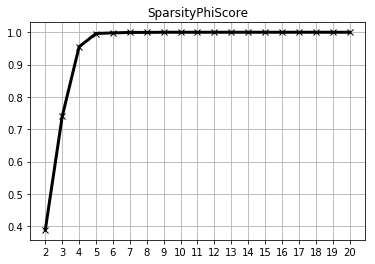

In [25]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [26]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

[0.3, 0.7, 0.9, 1.0]

In [27]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

{0.3: 1, 0.7: 1, 0.9: 5, 1.0: 12}

Text(0.5, 1.0, 'SparsityThetaScore')

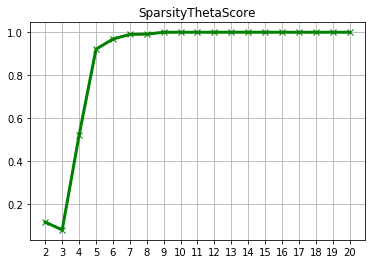

In [28]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [29]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

[0.0, 0.1, 0.5, 0.9, 1.0]

In [30]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

{0.0: 1, 0.1: 1, 0.5: 1, 0.9: 4, 1.0: 12}

Text(0.5, 1.0, 'PerplexityScore')

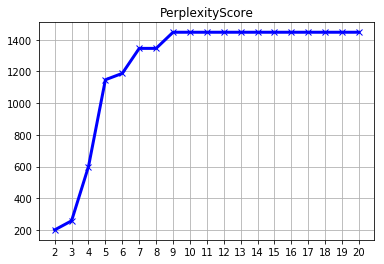

In [31]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [32]:
perplexity

[200.37644958496094,
 257.8155517578125,
 599.8652954101562,
 1147.3829345703125,
 1187.73681640625,
 1345.2698974609375,
 1345.2698974609375,
 1447.0447998046875,
 1447.0447998046875,
 1447.0447998046875,
 1447.0447998046875,
 1447.0447998046875,
 1447.0447998046875,
 1447.0447998046875,
 1447.0447998046875,
 1447.0447998046875,
 1447.0447998046875,
 1447.0447998046875,
 1447.0447998046875]

### select the best model

In [33]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

d_sphi:   {0.3: 1, 0.7: 1, 0.9: 5, 1.0: 12}
d_stheta: {0.0: 1, 0.1: 1, 0.5: 1, 0.9: 4, 1.0: 12}


In [34]:
select_topics = 4 # u should choose number of topic

best_model = model_list[select_topics-2]
print(best_model.num_topics)

4


### print top words for each topics

In [35]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['период' 'экономика' 'спрос' 'индустрия' 'легпром' 'лизинг' 'увеличение'
 'расширение' 'кожевеннообувной' 'кредит']
topic_1: ['русский' 'республика' 'очень' 'текстиль' 'фабрика' 'появиться'
 'узбекистан' 'сотрудничество' 'достаточно' 'положительный']
topic_2: ['сеть' 'делегация' 'апрель' 'требование' 'контракт' 'детский' 'марка'
 'zara' 'день' 'бренд']
topic_3: ['использование' 'мода' 'технология' 'дизайнер' 'совещание' 'холдинг'
 'связать' 'учебный' 'сила' 'генеральный']


### get topics-docs matrix

shape theta: (4, 131)


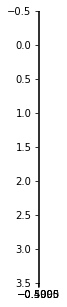

In [38]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(5, 5))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [39]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3
0,0.0,0.833333,0.166667,0.000000
1,0.0,0.166667,0.000000,0.833333
2,0.0,0.000000,0.000000,1.000000
3,0.0,0.000000,0.000000,1.000000
4,0.0,0.000000,0.000000,1.000000


## DataViz

In [40]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3
0,0,1999,12,0.0,0.833333,0.166667,0.000000
1,1,1999,11,0.0,0.166667,0.000000,0.833333
2,2,2000,6,0.0,0.000000,0.000000,1.000000
3,3,2001,2,0.0,0.000000,0.000000,1.000000
4,4,2001,9,0.0,0.000000,0.000000,1.000000


In [41]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (41, 4)


topic_0   topic_1   topic_2   topic_3
year month                                       
1999 11         0.0  0.166667  0.000000  0.833333
     12         0.0  0.833333  0.166667  0.000000
2000 6          0.0  0.000000  0.000000  1.000000
2001 2          0.0  0.000000  0.000000  1.000000
     9          0.0  0.000000  0.000000  1.000000

### straightforward matrix heatmap

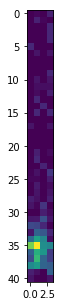

In [45]:
plt.figure(figsize=(5, 5))
plt.imshow(gb[topics])

## pygal

In [46]:
import pygal
from IPython.display import SVG, HTML

In [47]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [48]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [49]:
line_chart.render_to_file(f'data/visualization/{name_dataset}_pygal.svg')

## joypy

In [50]:
import joypy # !pip install joypy

In [51]:
print(joined.shape)
joined.head()

(142, 7)


,docID,year,month,topic_0,topic_1,topic_2,topic_3
0,0,1999,12,0.0,0.833333,0.166667,0.000000
1,1,1999,11,0.0,0.166667,0.000000,0.833333
2,2,2000,6,0.0,0.000000,0.000000,1.000000
3,3,2001,2,0.0,0.000000,0.000000,1.000000
4,4,2001,9,0.0,0.000000,0.000000,1.000000


In [52]:
joined['year_month'] = joined.apply(lambda x: str(int(x.year)) +'-'+ str(int(x.month)) + '-01', axis=1)
joined.reset_index(inplace=True)

joined.head()

,index,docID,year,month,topic_0,topic_1,topic_2,topic_3,year_month
0,0,0,1999,12,0.0,0.833333,0.166667,0.000000,1999-12-01
1,1,1,1999,11,0.0,0.166667,0.000000,0.833333,1999-11-01
2,2,2,2000,6,0.0,0.000000,0.000000,1.000000,2000-6-01
3,3,3,2001,2,0.0,0.000000,0.000000,1.000000,2001-2-01
4,4,4,2001,9,0.0,0.000000,0.000000,1.000000,2001-9-01


In [53]:
joined_melt = joined.melt('year_month', var_name='topic', value_name='text')
print(joined_melt.shape)
joined_melt.head()

(1136, 3)


,year_month,topic,text
0,1999-12-01,index,0.0
1,1999-11-01,index,1.0
2,2000-6-01,index,2.0
3,2001-2-01,index,3.0
4,2001-9-01,index,4.0


In [54]:
# select only topic_*
joined_melt_new = joined_melt[(joined_melt.topic!='docID') & (joined_melt.topic!='index')
                              & (joined_melt.topic!='year') & (joined_melt.topic!='month')]
print(joined_melt_new.shape)
joined_melt_new.topic.value_counts()

(568, 3)


topic_0    142
topic_1    142
topic_3    142
topic_2    142
Name: topic, dtype: int64

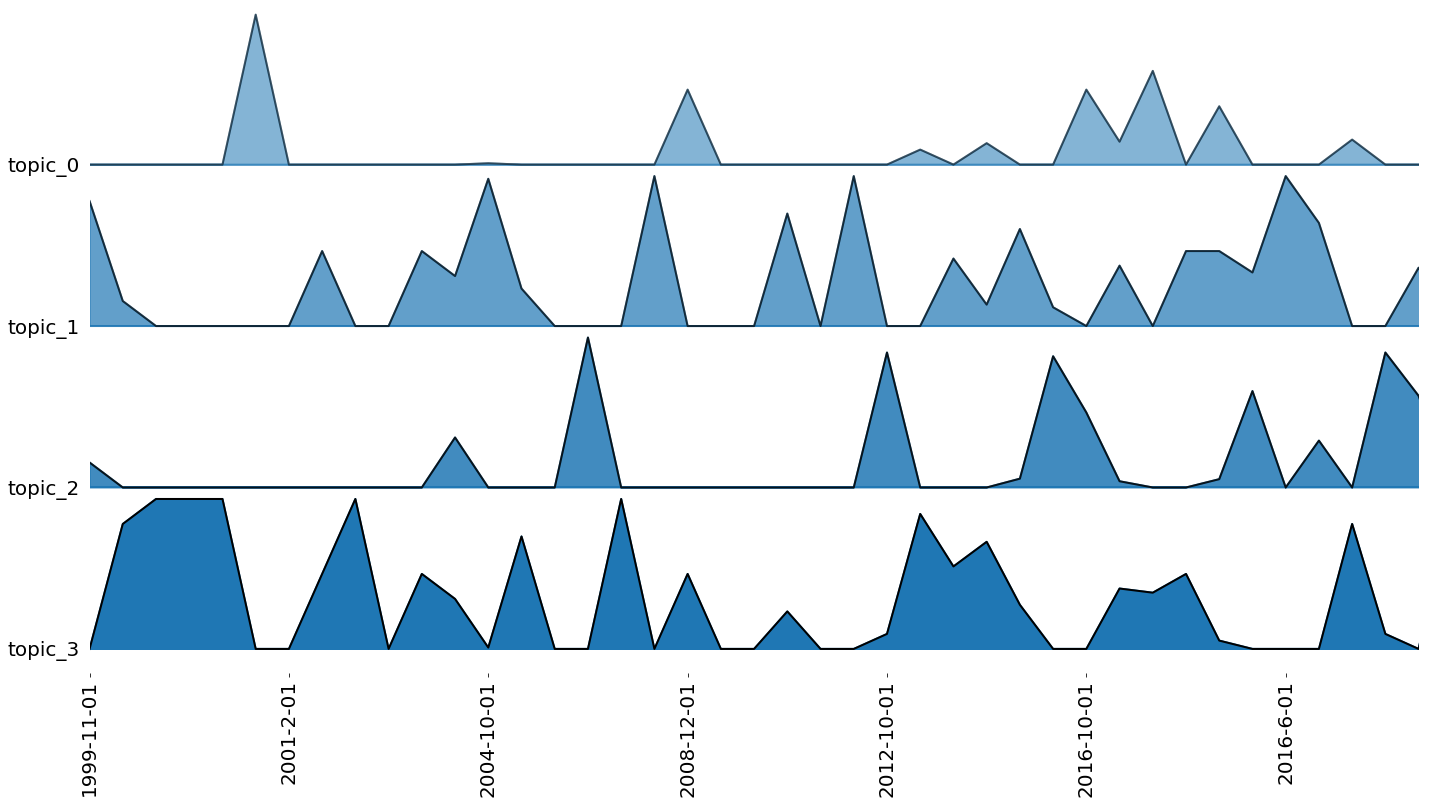

In [55]:
labels = sorted(joined_melt_new['year_month'].unique())

fig, axes = joypy.joyplot(joined_melt_new, by='topic', column='text', figsize=(20, 10),xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True, linecolor="k", linewidth=2,
                          kind='values', fade=True, xrot=90, x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [56]:
fig.savefig(f"data/visualization/{'-'.join(name_dataset.split('.'))}_joypy")